In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [42]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [43]:
# Filtrar datos por subestación y alimentador, si es necesario
substation = 'A'  # Cambia según tu dataset
feeder = 'A1'      # Cambia según tu dataset
data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]

In [44]:
# Seleccionar únicamente la columna de consumo
consumption_data = data_filtered['consumption']

In [45]:
# Comprobar si la serie está vacía o contiene solo NaN
if consumption_data.dropna().empty:
    print("La serie de consumo está vacía o contiene solo valores NaN.")
else:
    print("Serie de consumo cargada con éxito.")

    # Comprobar si la serie es estacionaria
    result = adfuller(consumption_data.dropna())
    print('p-value de la prueba Dickey-Fuller:', result[1])

    # Si el p-value es mayor a 0.05, diferenciamos la serie para hacerla estacionaria
    if result[1] > 0.05:
        consumption_data_diff = consumption_data.diff().dropna()
        print("Se aplicó diferenciación para hacer la serie estacionaria.")
    else:
        consumption_data_diff = consumption_data

Serie de consumo cargada con éxito.
p-value de la prueba Dickey-Fuller: 1.6215079139561128e-18


In [48]:
    # Entrenar el modelo ARIMA
p, d, q = 1, 1, 1  # Valores iniciales de los parámetros ARIMA
model = ARIMA(consumption_data_diff, order=(p, d, q))
model_fit = model.fit()
print("Modelo ARIMA entrenado.")

    # Predecir valores durante el tiempo del dataset
    # Para predecir un valor futuro, vamos a almacenar las predicciones
predictions = []
n_forecast = len(consumption_data)  # Número de pasos a predecir igual al tamaño de la serie

    # Hacer predicciones paso a paso
for _ in range(n_forecast):
    forecast = model_fit.forecast(steps=1)  # Predicción de un paso adelante
    predictions.append(forecast[0])  # Guardar la predicción
        # Actualizar el modelo con la serie aumentada
    consumption_data_diff = consumption_data_diff.append(pd.Series(forecast))
    model = ARIMA(consumption_data_diff, order=(p, d, q))
    model_fit = model.fit()  # Volver a ajustar el modelo

    # Convertir predicciones en una serie temporal
predicted_index = pd.date_range(start=consumption_data.index[-1] + pd.Timedelta(days=1), 
                                      periods=n_forecast, freq='D')
predicted_series = pd.Series(predictions, index=predicted_index)

IndentationError: expected an indented block after 'for' statement on line 13 (997702486.py, line 14)

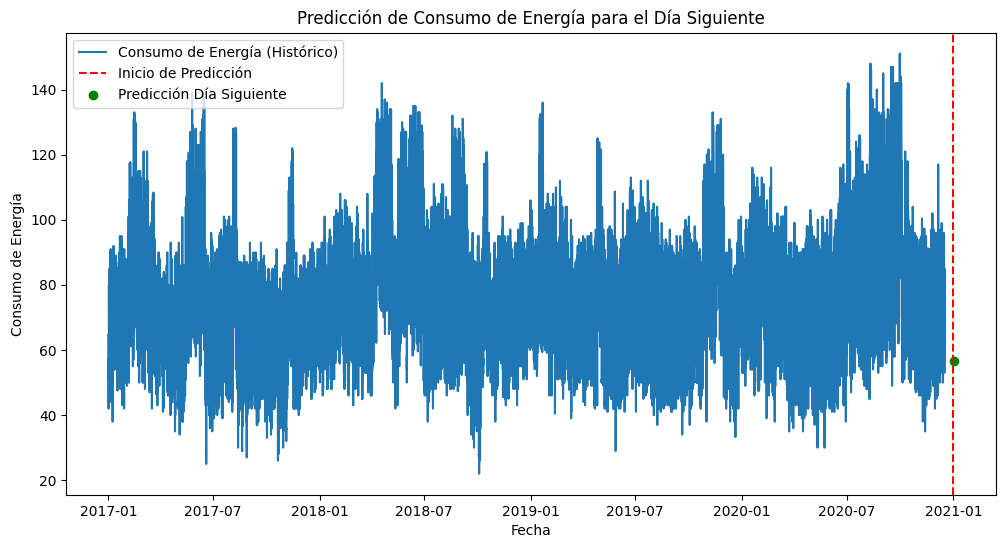

In [47]:
   # Graficar la serie original y la predicción
plt.figure(figsize=(12, 6))
plt.plot(consumption_data, label='Consumo de Energía (Histórico)')
plt.axvline(consumption_data.index[-1], color='red', linestyle='--', label='Inicio de Predicción')
plt.scatter(consumption_data.index[-1] + pd.Timedelta(days=1), forecast_value, color='green', label='Predicción Día Siguiente')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicción de Consumo de Energía para el Día Siguiente')
plt.legend()
plt.show()